# Load Required Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import TensorBoard
from keras.utils import to_categorical



# Loading and Preparing the Data

In [2]:
# Set a random seed for reproducibility.
np.random.seed(1648)
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

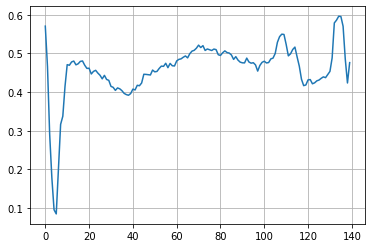

In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(140), train_data[0])
plt.show()

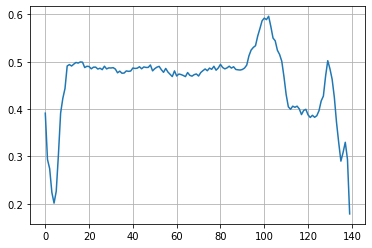

In [4]:
plt.grid()
plt.plot(np.arange(140), train_data[100])
plt.show()

All the above code for loading and preparing the data was provided by Richard Jiang.

In [5]:
# the model requires a 3-dimensional input therefore, we need to expand the 
# dimensions of the training and testing data.
train_data = np.expand_dims(train_data, 2)
test_data = np.expand_dims(test_data, 2)

# the model requires these to be in binary matrix form.
train_classes = to_categorical(train_labels, 2)
test_classes = to_categorical(test_labels, 2)

# Define Model Architecture

In [28]:
input_shape = (140, 1)
def buildmodel(filters, kernel_size, no_epochs, batch_size):
    #initiate a sequential keras model (sequential for simplicity)
    model = Sequential()
    #first two layers are convolutional.
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
                     input_shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    #dropout layer for regularisation
    model.add(Dropout(0.5))
    #pooling layer
    model.add(MaxPooling1D(pool_size=2))
    #outputs flattened to one long vector
    model.add(Flatten())
    #fully-connected layer
    model.add(Dense(100, activation='relu'))
    #output layer
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    #fit the network to our data
    model.fit(train_data, train_classes, epochs=no_epochs, batch_size=batch_size, 
              shuffle=True, validation_data=(test_data, test_classes),
              callbacks=[TensorBoard(log_dir='/tmp/model_cnn')])
    return model


# Optimise Parameters

Determining number of epochs

Epoch 1/10
40/40 [==============================] - 4s 75ms/step - loss: 0.5268 - accuracy: 0.7070 - val_loss: 0.1113 - val_accuracy: 0.9590
Epoch 2/10
40/40 [==============================] - 2s 62ms/step - loss: 0.0954 - accuracy: 0.9632 - val_loss: 0.0781 - val_accuracy: 0.9800
Epoch 3/10
40/40 [==============================] - 2s 62ms/step - loss: 0.0678 - accuracy: 0.9802 - val_loss: 0.0658 - val_accuracy: 0.9830
Epoch 4/10
40/40 [==============================] - 2s 62ms/step - loss: 0.0639 - accuracy: 0.9818 - val_loss: 0.0639 - val_accuracy: 0.9860
Epoch 5/10
40/40 [==============================] - 2s 62ms/step - loss: 0.0523 - accuracy: 0.9830 - val_loss: 0.0686 - val_accuracy: 0.9840
Epoch 6/10
40/40 [==============================] - 3s 67ms/step - loss: 0.0456 - accuracy: 0.9851 - val_loss: 0.0588 - val_accuracy: 0.9840
Epoch 7/10
40/40 [==============================] - 3s 63ms/step - loss: 0.0436 - accuracy: 0.9873 - val_loss: 0.0475 - val_accuracy: 0.9910
Epoch 8/10
40

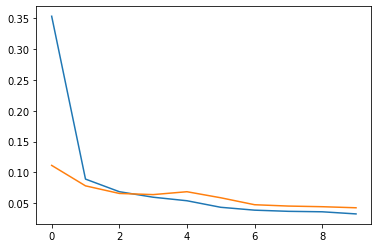

In [7]:
#build the model 
model = buildmodel(64, 3, 10, 100)
#plot the loss and the value loss over the different epochs.
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])

6 epochs seem to be enough to reach a low value loss and a high accuracy.

Need to repeat optimisation experiments various times for accuracy.

In [8]:
def buildmultiple(filters, kernel_size, no_epochs, batch_size):
  #initiate accuracy list.
  repeat_accuracy = []*10
  #for each repeat
  for i in range(10):
    #build the model
    model = buildmodel(filters, kernel_size, no_epochs, batch_size)
    #measure and record the accuracy
    loss, accuracy = model.evaluate(test_data, test_classes, 
                                          batch_size=batch_size)
    repeat_accuracy.append(accuracy)
  return repeat_accuracy

Number of filters

Epoch 1/6
40/40 [==============================] - 1s 21ms/step - loss: 0.6737 - accuracy: 0.5759 - val_loss: 0.5987 - val_accuracy: 0.5600
Epoch 2/6
40/40 [==============================] - 1s 15ms/step - loss: 0.4557 - accuracy: 0.8536 - val_loss: 0.2189 - val_accuracy: 0.9570
Epoch 3/6
40/40 [==============================] - 1s 14ms/step - loss: 0.1540 - accuracy: 0.9524 - val_loss: 0.1116 - val_accuracy: 0.9650
Epoch 4/6
40/40 [==============================] - 1s 15ms/step - loss: 0.0941 - accuracy: 0.9688 - val_loss: 0.0911 - val_accuracy: 0.9760
Epoch 5/6
40/40 [==============================] - 1s 15ms/step - loss: 0.0903 - accuracy: 0.9685 - val_loss: 0.0816 - val_accuracy: 0.9820
Epoch 6/6
10/10 [==============================] - 0s 5ms/step - loss: 0.0845 - accuracy: 0.9830
Epoch 1/6
40/40 [==============================] - 1s 24ms/step - loss: 0.6374 - accuracy: 0.6140 - val_loss: 0.4752 - val_accuracy: 0.9490
Epoch 2/6
40/40 [==============================] - 1s 15ms/step

{'boxes': [<matplotlib.lines.Line2D at 0x7f142f7d8a58>,
 'caps': [<matplotlib.lines.Line2D at 0x7f142f7d84e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1431826c18>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f14318260b8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f142f7d89e8>,
  <matplotlib.lines.Line2D at 0x7f1430722518>]}

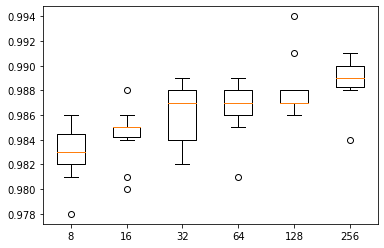

In [9]:
#list of number of filters to be tested.
filters = [8, 16, 32, 64, 128, 256]

#initiate filters vector list
filters_accuracy = []*6

#repeat following steps for each number of filters.
for i in range(len(filters)):
  accuracy = buildmultiple(filters[i], 3, 6, 100)
  filters_accuracy.append(accuracy)  

#boxplot of the accuracy scores for each corresponding number of filters 
#invesitgated. 
plt.boxplot(filters_accuracy, labels = filters)

128 may be more suitable (takes twice as long but still quick enough that it wouldn't be considered inefficient).

Kernel Size

Epoch 1/6
40/40 [==============================] - 6s 130ms/step - loss: 0.5982 - accuracy: 0.6484 - val_loss: 0.1480 - val_accuracy: 0.9570
Epoch 2/6
40/40 [==============================] - 5s 124ms/step - loss: 0.1290 - accuracy: 0.9474 - val_loss: 0.1094 - val_accuracy: 0.9680
Epoch 3/6
40/40 [==============================] - 5s 124ms/step - loss: 0.0704 - accuracy: 0.9788 - val_loss: 0.0683 - val_accuracy: 0.9820
Epoch 4/6
40/40 [==============================] - 5s 124ms/step - loss: 0.0689 - accuracy: 0.9776 - val_loss: 0.0808 - val_accuracy: 0.9780
Epoch 5/6
40/40 [==============================] - 5s 122ms/step - loss: 0.0658 - accuracy: 0.9785 - val_loss: 0.0612 - val_accuracy: 0.9850
Epoch 6/6
10/10 [==============================] - 0s 30ms/step - loss: 0.0560 - accuracy: 0.9870
Epoch 1/6
40/40 [==============================] - 7s 151ms/step - loss: 0.6340 - accuracy: 0.6379 - val_loss: 0.2303 - val_accuracy: 0.9550
Epoch 2/6
40/40 [==============================] - 5s 13

{'boxes': [<matplotlib.lines.Line2D at 0x7f142fb0c588>,
 'caps': [<matplotlib.lines.Line2D at 0x7f142fe0fa58>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f142fe0f240>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f142fe0fda0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f142fb0c0f0>,
  <matplotlib.lines.Line2D at 0x7f14329a30b8>]}

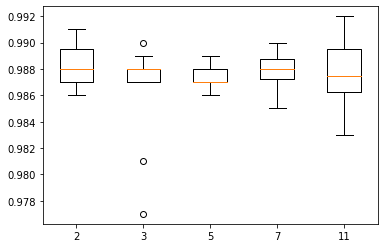

In [10]:
#different kernel sizes to investigate.
kernel = [2, 3, 5, 7, 11]

#initiate accuracy list.
kernel_accuracy = []*5

#repeat following steps for each kernel size.
for i in range(len(kernel)):
  accuracy = buildmultiple(128, kernel[i], 6, 100)
  kernel_accuracy.append(accuracy)  

#boxplots of the accuracy scores corresponding to each kernel size investigated. 
plt.boxplot(kernel_accuracy, labels = kernel)

A kernel size of 3 seems fine (less variation and not much of a mean difference in accuracy across kernel sizes)

Batch Size

Epoch 1/6
500/500 [==============================] - 12s 23ms/step - loss: 0.3230 - accuracy: 0.8212 - val_loss: 0.0649 - val_accuracy: 0.9790
Epoch 2/6
500/500 [==============================] - 11s 22ms/step - loss: 0.0636 - accuracy: 0.9774 - val_loss: 0.0459 - val_accuracy: 0.9890
Epoch 3/6
500/500 [==============================] - 11s 22ms/step - loss: 0.0429 - accuracy: 0.9830 - val_loss: 0.0531 - val_accuracy: 0.9810
Epoch 4/6
500/500 [==============================] - 11s 22ms/step - loss: 0.0342 - accuracy: 0.9878 - val_loss: 0.0449 - val_accuracy: 0.9920
Epoch 5/6
500/500 [==============================] - 11s 22ms/step - loss: 0.0296 - accuracy: 0.9918 - val_loss: 0.0373 - val_accuracy: 0.9890
Epoch 6/6
125/125 [==============================] - 1s 5ms/step - loss: 0.0419 - accuracy: 0.9920
Epoch 1/6
500/500 [==============================] - 12s 23ms/step - loss: 0.3161 - accuracy: 0.8293 - val_loss: 0.0665 - val_accuracy: 0.9770
Epoch 2/6
500/500 [========================

{'boxes': [<matplotlib.lines.Line2D at 0x7f14318fde48>,
 'caps': [<matplotlib.lines.Line2D at 0x7f142fd3cbe0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f14318b1978>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1430709320>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f142fbd2518>,
  <matplotlib.lines.Line2D at 0x7f14318613c8>]}

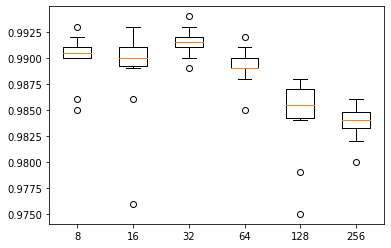

In [11]:
#list of batch sizes to be tested.
batch = [8, 16, 32, 64, 128, 256]

#initiate accuracy list.
batch_accuracy = []*6

#repeat following steps for each batch size.
for i in range(len(batch)):
  accuracy = buildmultiple(128, 3, 6, batch[i])
  batch_accuracy.append(accuracy)  

#boxplot of the accuracy scores against the corresponding batch sizes 
#investigated. 
plt.boxplot(batch_accuracy, labels = batch)

32 looks like the optimal batch size.

Much of the above code was taken from Jason Brownlee (https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/) and manipulated for the ECG data.

# Model Performance

Performance Metrics for data provided.

In [18]:
#initiate performance metrics lists.
accuracy1 = []*10
precision1 = []*10
recall1 = []*10
f1_1 = []*10

#repeat 10 times for accuracy.
for i in range(10):
  #build model and predict for the test data.
  model1 = buildmodel(128, 3, 6, 32)
  #calculate and record performance metrics.
  pred1 = model1.predict_classes(test_data)
  accuracy1.append(accuracy_score(test_labels, pred1))
  precision1.append(precision_score(test_labels, pred1))
  recall1.append(recall_score(test_labels, pred1))
  f1_1.append(f1_score(test_labels, pred1))

Epoch 1/6
125/125 [==============================] - 8s 61ms/step - loss: 0.4372 - accuracy: 0.7836 - val_loss: 0.0940 - val_accuracy: 0.9740
Epoch 2/6
125/125 [==============================] - 8s 61ms/step - loss: 0.0852 - accuracy: 0.9735 - val_loss: 0.0822 - val_accuracy: 0.9840
Epoch 3/6
125/125 [==============================] - 7s 59ms/step - loss: 0.0674 - accuracy: 0.9806 - val_loss: 0.0563 - val_accuracy: 0.9870
Epoch 4/6
125/125 [==============================] - 7s 59ms/step - loss: 0.0388 - accuracy: 0.9897 - val_loss: 0.0480 - val_accuracy: 0.9890
Epoch 5/6
125/125 [==============================] - 7s 59ms/step - loss: 0.0366 - accuracy: 0.9899 - val_loss: 0.0486 - val_accuracy: 0.9930
Epoch 6/6
125/125 [==============================] - 7s 59ms/step - loss: 0.0342 - accuracy: 0.9903 - val_loss: 0.0508 - val_accuracy: 0.9870


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/6
125/125 [==============================] - 8s 60ms/step - loss: 0.4383 - accuracy: 0.7535 - val_loss: 0.0911 - val_accuracy: 0.9750
Epoch 2/6
125/125 [==============================] - 7s 57ms/step - loss: 0.0848 - accuracy: 0.9746 - val_loss: 0.0621 - val_accuracy: 0.9840
Epoch 3/6
125/125 [==============================] - 7s 57ms/step - loss: 0.0608 - accuracy: 0.9817 - val_loss: 0.0509 - val_accuracy: 0.9880
Epoch 4/6
125/125 [==============================] - 7s 57ms/step - loss: 0.0415 - accuracy: 0.9857 - val_loss: 0.0702 - val_accuracy: 0.9860
Epoch 5/6
125/125 [==============================] - 7s 57ms/step - loss: 0.0527 - accuracy: 0.9867 - val_loss: 0.0417 - val_accuracy: 0.9940
Epoch 6/6
125/125 [==============================] - 7s 57ms/step - loss: 0.0426 - accuracy: 0.9873 - val_loss: 0.0393 - val_accuracy: 0.9910
Epoch 1/6
125/125 [==============================] - 8s 59ms/step - loss: 0.3739 - accuracy: 0.8196 - val_loss: 0.0751 - val_accuracy: 0.9760
Epoch 

Load in a second dataset for comparison (the data was taken from these sources: https://www.kaggle.com/shayanfazeli/heartbeat?select=ptbdb_abnormal.csv and https://www.kaggle.com/shayanfazeli/heartbeat?select=ptbdb_normal.csv). 2500 observations were taken from each and then combined into the dataset used below.

In [22]:
dataframe = pd.read_csv('https://raw.githubusercontent.com/chloeworthington/SCC413-Computer-Vision-Coursework/main/ecgdata.csv', header = None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,0.649870,0.635100,0.655083,0.664639,0.633362,0.746308,0.871416,0.938314,1.000000,0.948740,0.396177,0.000000,0.039096,0.128584,0.305821,0.640313,0.617724,0.537793,0.352737,0.220678,0.256299,0.357950,0.482189,0.570808,0.577758,0.620330,0.622068,0.618593,0.626412,0.612511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,0.125101,0.129136,0.137207,0.137207,0.132365,0.126715,0.158192,0.152542,0.132365,0.168684,0.156578,0.183212,0.191283,0.204197,0.230024,0.244552,0.285714,0.307506,0.321227,0.327684,0.351897,0.373688,0.397094,0.363196,0.340597,0.307506,0.258273,0.197740,0.199354,0.173527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,0.681260,0.616743,0.624424,0.619816,0.596006,0.627496,0.631336,0.619048,0.612903,0.613671,0.607527,0.586790,0.568356,0.543779,0.526882,0.552995,0.577573,0.592166,0.576037,0.579109,0.573733,0.589862,0.542243,0.519201,0.514593,0.528418,0.493856,0.485407,0.461598,0.478495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,0.357671,0.379852,0.375231,0.397412,0.388170,0.378004,0.398336,0.419593,0.427911,0.402033,0.378928,0.400185,0.406654,0.422366,0.402033,0.383549,0.398336,0.393715,0.417745,0.388170,0.360444,0.402957,0.392791,0.413124,0.377079,0.327172,0.346580,0.338262,0.356747,0.314233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,0.285566,0.343718,0.281412,0.281412,0.283489,0.281412,0.319834,0.311526,0.283489,0.278297,0.274143,0.317757,0.267913,0.275182,0.280374,0.255452,0.313603,0.266874,0.244029,0.198339,0.192108,0.190031,0.134995,0.086189,0.078920,0.036345,0.024922,0.000000,0.044652,0.024922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


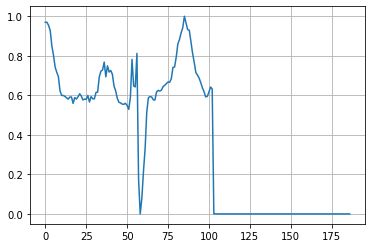

In [23]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(187), train_data[0])
plt.show()

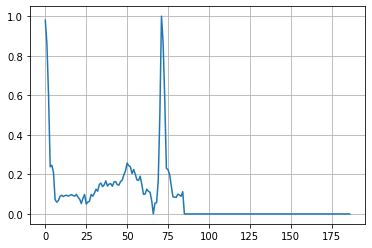

In [24]:
plt.grid()
plt.plot(np.arange(187), train_data[100])
plt.show()

In [25]:
# the model requires a 3-dimensional input therefore, we need to expand the 
# dimensions of the training and testing data.
train_data = np.expand_dims(train_data, 2)
test_data = np.expand_dims(test_data, 2)

# the model requires these to be in binary matrix form.
train_classes = to_categorical(train_labels, 2)
test_classes = to_categorical(test_labels, 2)

Performance metrics for second data

In [29]:
#initiate performance metrics lists.
accuracy2 = []*10
precision2 = []*10
recall2 = []*10
f1_2 = []*10

#change input shape
input_shape = (187, 1)

#repeat 10 times for accuracy.
for i in range(10):
  #build model and predict for the test data.
  model2 = buildmodel(128, 3, 6, 32)
  #calculate and record performance metrics.
  pred2 = model2.predict_classes(test_data)
  accuracy2.append(accuracy_score(test_labels, pred2))
  precision2.append(precision_score(test_labels, pred2))
  recall2.append(recall_score(test_labels, pred2))
  f1_2.append(f1_score(test_labels, pred2))

Epoch 1/6
125/125 [==============================] - 10s 80ms/step - loss: 0.5859 - accuracy: 0.6754 - val_loss: 0.4696 - val_accuracy: 0.7910
Epoch 2/6
125/125 [==============================] - 9s 76ms/step - loss: 0.4144 - accuracy: 0.8129 - val_loss: 0.3882 - val_accuracy: 0.8200
Epoch 3/6
125/125 [==============================] - 10s 77ms/step - loss: 0.3443 - accuracy: 0.8479 - val_loss: 0.3589 - val_accuracy: 0.8310
Epoch 4/6
125/125 [==============================] - 9s 75ms/step - loss: 0.3061 - accuracy: 0.8665 - val_loss: 0.2889 - val_accuracy: 0.8960
Epoch 5/6
125/125 [==============================] - 9s 76ms/step - loss: 0.2546 - accuracy: 0.8950 - val_loss: 0.2482 - val_accuracy: 0.9250
Epoch 6/6
125/125 [==============================] - 10s 76ms/step - loss: 0.2203 - accuracy: 0.9071 - val_loss: 0.2297 - val_accuracy: 0.9200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/6
125/125 [==============================] - 10s 78ms/step - loss: 0.5276 - accuracy: 0.7183 - val_loss: 0.4225 - val_accuracy: 0.8150
Epoch 2/6
125/125 [==============================] - 9s 76ms/step - loss: 0.3805 - accuracy: 0.8329 - val_loss: 0.3432 - val_accuracy: 0.8530
Epoch 3/6
125/125 [==============================] - 9s 76ms/step - loss: 0.3221 - accuracy: 0.8507 - val_loss: 0.2986 - val_accuracy: 0.8890
Epoch 4/6
125/125 [==============================] - 9s 76ms/step - loss: 0.2900 - accuracy: 0.8774 - val_loss: 0.2797 - val_accuracy: 0.8860
Epoch 5/6
125/125 [==============================] - 9s 76ms/step - loss: 0.2129 - accuracy: 0.9178 - val_loss: 0.2298 - val_accuracy: 0.9310
Epoch 6/6
125/125 [==============================] - 9s 75ms/step - loss: 0.1819 - accuracy: 0.9258 - val_loss: 0.2210 - val_accuracy: 0.9320
Epoch 1/6
125/125 [==============================] - 10s 77ms/step - loss: 0.5527 - accuracy: 0.7136 - val_loss: 0.4598 - val_accuracy: 0.7940
Epoc

Collate the performance metrics into a dataframe and save for later direct comparison.

In [31]:
cnnperf = pd.DataFrame()
cnnperf["Accuracy1"] = accuracy1
cnnperf["Precision1"] = precision1
cnnperf["Recall1"] = recall1
cnnperf["F1Score1"] = f1_1
cnnperf["Accuracy2"] = accuracy2
cnnperf["Precision2"] = precision2
cnnperf["Recall2"] = recall2
cnnperf["F1Score2"] = f1_2

cnnperf.to_csv("CNN_performance_metrics.csv")